In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ipyvolume as ipv
from ipywidgets import FloatProgress
from IPython.display import display, Image

from tyssue import HistoryHdf5, EventManager

from tyssue.draw import sheet_view, browse_history
from tyssue.geometry.bulk_geometry import ClosedMonolayerGeometry as geom
from tyssue.io import hdf5
from tyssue.dynamics import model_factory, effectors
from tyssue.generation.shapes import spherical_monolayer

from tyssue.behaviors import EventManager
from tyssue.behaviors import increase, decrease, reconnect
from tyssue.solvers.viscous import EulerSolver
from tyssue.utils.decorators import face_lookup


from tyssue.draw import highlight_faces, create_gif, highlight_cells
from tyssue.solvers.quasistatic import QSSolver


from tyssue import HistoryHdf5



from pathlib import Path

from tyssue.utils.decorators import cell_lookup
from tyssue.topology.monolayer_topology import cell_division

from tyssue.dynamics import units
from tyssue.dynamics.sheet_gradients import area_grad

from tyssue.utils import to_nd


In [2]:
import logging
logger = logging.getLogger("tyssue")
logger.setLevel("DEBUG")
handled = False
if not handled:
    hand = logging.FileHandler("follicle.log")
    hand.setLevel("INFO")
    logger.addHandler(hand)
    handled = True


Reference: https://elifesciences.org/articles/32943


It is conveninent to consider that cells have an average volume of 1


| stade  | nombe de cellules | volume interne (μm3) |
| ------ | --------- | ---------- |
| 3 | 120 | 181008 |
| 4 | 200 | 670400 |
| 5 | 400 | 3352000 | 
| 6 | 700 | 12318600 | 

## Experimental data

In [3]:
growth = pd.DataFrame(
    data=[[120, 181000], [200, 670400], [400, 3352000], [700, 12318600]],
    index=pd.Index([3, 4, 5, 6], name='stage'),
    columns=['Nc', 'lumen_vol']
)
growth

,Nc,lumen_vol
stage,,
3,120,181000
4,200,670400
5,400,3352000
6,700,12318600


$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



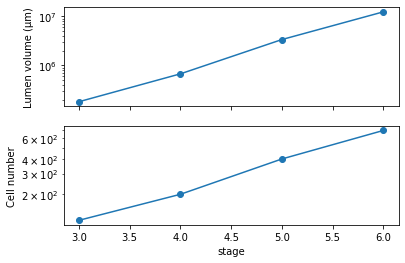

In [4]:
fig, (ax_v, ax_c) = plt.subplots(2, sharex=True)

ax_v.plot(growth.lumen_vol, '-o')
ax_v.set_yscale('log')
ax_v.set_ylabel('Lumen volume (µm)')

ax_c.plot(growth.Nc, '-o')
ax_c.set_yscale('log')
ax_c.set_ylabel('Cell number')
_ = ax_c.set_xlabel("stage")


In [5]:
kV, lnV0 = np.polyfit(growth.index, np.log(growth.lumen_vol), 1)

print(f"Lumen volume growth rate: {kV:.2f}")

kD, lnc0 = np.polyfit(growth.index, np.log(growth.Nc), 1)

print(f"Division rate: {kD:.2f}")


Lumen volume growth rate: 1.43
Division rate: 0.60


## Follicle monolayer creation


In [6]:
# Number of cells
Nc = 200

In [11]:
follicle = spherical_monolayer(9., 12., Nc, apical='in')
follicle.settings["lumen_side"] = "apical"

geom.update_all(follicle)
geom.scale(follicle, follicle.cell_df.vol.mean()**(-1/3), list("xyz"))
geom.update_all(follicle)


for df in follicle.datasets.values():
    if np.nan in df:
        print(f"nan values in {df.index.name}")
    df.dropna(axis=1, how='any', inplace=True)

print(f"Follicle has {follicle.Nc} cells")

Follicle has 208 cells


In [12]:
print(follicle.settings)

{'lumen_side': 'apical', 'lumen_vol': 154.13740035666262}


In [13]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [14]:
ipv.clear()
follicle.face_df['visible'] = (follicle.face_df['y'] > 0) | (follicle.face_df['x'] > 0)
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [15]:
bck0 = follicle.copy()

## Mechanical model


By analogy with 2D Manning model (by a suggestion she did during a communication, I assume this will be published some time) we can write the basic potiential with

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{K_v}{2}(V_c - V_c^0)^2 + \frac{K_A}{2}(A_c - A_c^0)^2
$$

By setting $V_c^0 = 1$ and $K_c^0 = 1$, we rewrite this:

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{1}{2}(V_c - 1)^2 + \frac{K_A}{2}(A_c - s^0)^2
$$

Here $s^0$ is the form factor (as in 2D)

For a sphere, the ratio $A / V^{2/3}$ is equal to $(36\pi)^{1/3} \approx 4.84$

For a [truncated octahedron](https://en.wikipedia.org/wiki/Truncated_octahedron) (regular cells in bulk), it's 5.31 and 8.14 for a honeycomb (cuboidal cells).

In [16]:
sphere = (36*np.pi)**(1/3)
truncocta = (6 + 12 * 3**0.5) / (4 * 2**(1/3))
honeycomb = (3*3**0.5 + 6) / ((3/2) * 3**0.5)**(1/3)


print(sphere, truncocta, honeycomb)

4.835975862049408 5.314739699971957 8.144257693571506


In [17]:
follicle = bck0.copy()

model = model_factory([
    effectors.LumenVolumeElasticity,
    effectors.CellAreaElasticity,
    effectors.CellVolumeElasticity,
    ])



specs = {
    'cell': {
        'is_alive': 1,
        'vol_elasticity': 1.0,
        'prefered_vol': 1.0, # so that we have some variability
        'area_elasticity': 0.1,
        'prefered_area': 4.6, # form factor
    },
    'face': {
        'is_alive': 1,
    },
    'settings': {
        'lumen_vol_elasticity': 100.,
        'lumen_prefered_vol': 200,
    }
}

follicle.update_specs(specs, reset=True)



In [18]:
follicle.settings

{'lumen_side': 'apical',
 'lumen_vol': 154.13740035666262,
 'lumen_vol_elasticity': 100.0,
 'lumen_prefered_vol': 200}

In [19]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)



b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [20]:
ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)
# reset full visibility
# follicle.face_df['visible'] = True
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [21]:
r_a = np.linalg.norm(
    follicle.vert_df.loc[follicle.apical_verts, ['x', 'y', 'z']],
    axis=1
)
r_b = np.linalg.norm(
    follicle.vert_df.loc[follicle.basal_verts, ['x', 'y', 'z']],
    axis=1
)
rho = r_b.mean()/r_a.mean()
print(f"rho : {rho: .2f}")
print(f"mean apical radius: {r_a.mean(): .3f}")

rho :  1.23
mean apical radius:  3.653


## Cell area as a weighted sum of face areas


For now the model is isotropic, so cells will tend to adopt the most spherical shape possible. In order to have polarisation, we can introduce a factor (or weight) on each face of the cell to modulate its effective contribution to the total area, the total area $A_c$ is replaced by the weighted area $A'_c$:

$$
A_c = \sum_f A_f \quad \mbox{becomes}\\
A'_c = \frac{n_f}{\sum_f w_f}\sum_f w_fA_f
$$

If all the weights are equal, the weighted area is equal to the normal area.

We need to adapt our model definition to take this into account:





In [22]:


class WAMonolayerGeometry(geom):

    @classmethod
    def update_all(cls, eptm):
        
        super().update_all(eptm)
        cls.normalize_face_weights(eptm)
        cls.update_weithed_area(eptm)
        
    @staticmethod
    def normalize_face_weights(eptm):
        
        eptm.face_df["cell"] = eptm.edge_df.groupby("face")['cell'].first()
        sum_weights = eptm.face_df.groupby("cell")["weight"].sum()
        weight_norm = (eptm.cell_df['num_faces'] / sum_weights).loc[eptm.face_df["cell"].to_numpy()]
        eptm.face_df["weight"] *= weight_norm.to_numpy()
        
    @staticmethod
    def update_weithed_area(eptm):
        eptm.edge_df["face_weight"] = eptm.upcast_face(eptm.face_df['weight'])
        eptm.cell_df["weighted_area"] = eptm.sum_cell(eptm.edge_df.eval("sub_area * face_weight"))


class WeightedCellAreaElasticity(effectors.AbstractEffector):
    
    dimensions = units.area_elasticity
    magnitude = "area_elasticity"
    label = "Weighted Area elasticity"
    element = "cell"
    specs = {
        "cell": {
            "is_alive": 1,
            "weighted_area": 1.0,
            "area_elasticity": 1.0,
            "prefered_area": 1.0,
        },
        "face": {
            "area": 1.0,
            "weight": 1.0,
        }
    }
    spatial_ref = "prefered_area", units.area

    @staticmethod
    def get_nrj_norm(specs):
        return specs["cell"]["area_elasticity"] * specs["cell"]["prefered_area"] ** 2

    @staticmethod
    def energy(eptm):
        
        return effectors.elastic_energy(
            eptm.cell_df,
            "weighted_area", 
            "area_elasticity * is_alive", "prefered_area")

    @staticmethod
    def gradient(eptm):
        ka_a0_ = effectors.elastic_force(
            eptm.cell_df, "weighted_area", "area_elasticity * is_alive", "prefered_area"
        )
        face_weight = eptm.edge_df["face_weight"].to_numpy()
        
        ka_a0 = to_nd(eptm.upcast_cell(ka_a0_) * face_weight, 3)

        grad_a_srce, grad_a_trgt = area_grad(eptm)

        
        grad_a_srce = ka_a0 * grad_a_srce
        grad_a_trgt = ka_a0 * grad_a_trgt
        grad_a_srce.columns = ["g" + u for u in eptm.coords]
        grad_a_trgt.columns = ["g" + u for u in eptm.coords]

        return grad_a_srce, grad_a_trgt
    


In [23]:
wgeom = WAMonolayerGeometry

follicle = bck0.copy()

model = model_factory([
    effectors.LumenVolumeElasticity,
    WeightedCellAreaElasticity,
    effectors.CellVolumeElasticity,
    ])


specs = {
    'cell': {
        'is_alive': 1,
        'vol_elasticity': 1.0,
        'prefered_vol': 1.0,
        "weighted_area": 1.0,
        'area_elasticity': 0.01,
        'prefered_area': 4.0, # form factor
    },
    'face': {
        'weight': 1.0,
        'is_alive': 1,
    },
    'settings': {
        'lumen_vol_elasticity': 1.e-3,
        'lumen_prefered_vol': 160,
    }
}

follicle.update_specs(specs, reset=True)



#follicle.face_df['surface_tension'] = 10.0
follicle.face_df["weight"] = 1.0
follicle.face_df.loc[follicle.apical_faces, 'weight'] = 1.0
wgeom.update_all(follicle)

In [24]:
solver = QSSolver()
res = solver.find_energy_min(follicle, wgeom, model)
print(res.message)


draw_specs["face"]["color"] = follicle.face_df['area']

ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)
# reset full visibility
# follicle.face_df['visible'] = True
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [25]:
r_a = np.linalg.norm(
    follicle.vert_df.loc[follicle.apical_verts, ['x', 'y', 'z']],
    axis=1
)
r_b = np.linalg.norm(
    follicle.vert_df.loc[follicle.basal_verts, ['x', 'y', 'z']],
    axis=1
)
rho = r_b.mean()/r_a.mean()
print(f"rho : {rho: .2f}")

rho :  1.30


In [26]:
follicle.cell_df.area.mean()

5.593348654312971

In [27]:
follicle.cell_df.vol.mean()

0.93626751073455


## follicle.settings

In [28]:

def contractility_grad(follicle, cell, amp, span, coords=['x', 'y', 'z'], elem="face"):
    
    cell_pos = follicle.cell_df.loc[cell, coords].to_numpy()
    distance = np.linalg.norm(
        follicle.datasets[elem][coords] - cell_pos[None, :],
        axis=1)
    
    grad = amp * np.exp(-distance / span)
    return grad# - grad.min()


In [29]:
bck1 = follicle.copy()

## Static contractility gradient

In [30]:
follicle = bck1.copy()

anterior_cell = follicle.cell_df['z'].idxmin() 
posterior_cell = follicle.cell_df['z'].idxmax() 
anterior_faces = follicle.edge_df.query(f'cell == {anterior_cell}')["face"].unique()
posterior_faces = follicle.edge_df.query(f'cell == {posterior_cell}')["face"].unique()

face_gradient = (
    contractility_grad(follicle, anterior_cell, amp=6.0, span=1)
    + contractility_grad(follicle, posterior_cell, amp=6.0, span=1)
)


follicle.face_df["contractile_grad"] = face_gradient

follicle.face_df.loc[anterior_faces, "contractile_grad"] = 1
follicle.face_df.loc[posterior_faces, "contractile_grad"] = 1

follicle.face_df["weight"] = 1.0
follicle.face_df.loc[follicle.apical_faces, "weight"] += follicle.face_df.loc[
    follicle.apical_faces, "contractile_grad"]
wgeom.update_all(follicle)


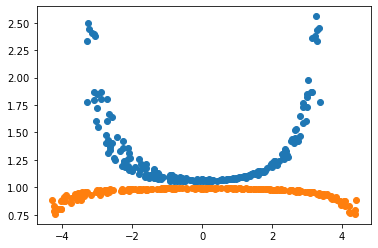

In [31]:
fig, ax = plt.subplots()
ax.plot(follicle.face_df.loc[follicle.apical_faces, "z"],
        follicle.face_df.loc[follicle.apical_faces, "weight"], 'o')
ax.plot(follicle.face_df.loc[follicle.basal_faces, "z"],
        follicle.face_df.loc[follicle.basal_faces, "weight"], 'o')

In [32]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [33]:

ipv.clear()
follicle.face_df['visible'] = True
follicle.face_df.loc[follicle.basal_faces, 'visible'] = False

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [34]:
quasistatic_solve = True

if quasistatic_solve:
    solver = QSSolver()
    res = solver.find_energy_min(follicle, wgeom, model)
    print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [35]:

ipv.clear()
follicle.face_df['visible'] = False
follicle.face_df.loc[follicle.apical_faces, 'visible'] = True

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [36]:
import ipywidgets as widgets
from IPython.display import display

class MonolayerView(widgets.HBox):
    
    def __init__(self, eptm):
        
        plt.ioff()
        ipv.clear()
        self.fig3D, self.mesh = sheet_view(eptm, mode="3D", **draw_specs);
        self.graph_widget = widgets.Output()
        with self.graph_widget:
            
            self.fig2D, (self.ax0, self.ax1) = plt.subplots(2, 1, sharey=True, sharex=True)
            apical = eptm.get_sub_sheet('apical')
            apical.reset_index(),
            apical.reset_topo(),
            apical.face_df['visisble'] = True            
            _ = sheet_view(
                apical,
                mode="2D", 
                coords=["x", "y"],
                ax=self.ax0,
                edge={"visible": False},
                face={
                    "visible": True,
                    "color": apical.face_df.area
                }
            )
            basal = eptm.get_sub_sheet('basal')
            basal.face_df['visible'] = True            
            basal.reset_index(),
            basal.reset_topo(),
            _ = sheet_view(
                basal,
                mode="2D",
                coords=["x", "y"],
                ax=self.ax1,
                edge={"visible": False},
                face={
                    "visible": True,
                    "color": basal.face_df.area
                }
            )
            self.ax0.set_title('Apical mesh')
            self.ax1.set_title('Basal mesh')
            self.fig2D.set_size_inches(5, 8)
            plt.close(self.fig2D)
            display(self.fig2D)
            
        super().__init__([self.fig3D, self.graph_widget])
        
        

In [38]:
MonolayerView(follicle)

MonolayerView(children=(Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(…

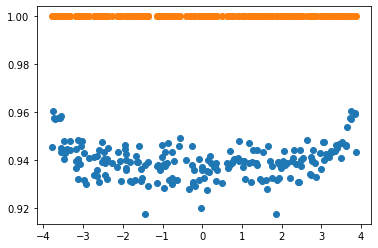

In [39]:
fig, ax = plt.subplots()

ax.plot(follicle.cell_df['z'], follicle.cell_df['vol'], "o")
ax.plot(follicle.cell_df['z'], follicle.cell_df['prefered_vol'], "o")


## Cell division and dynamic model

$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



In [40]:
bck1 = follicle

In [41]:
def reset_segments(monolayer):
    monolayer.get_opposite_faces()
    face_normals = monolayer.face_df[monolayer.coords].copy()
    
    for nu in monolayer.ncoords:
        face_normals[nu[1]] = monolayer.sum_face(
            monolayer.edge_df[nu])

    proj = (
        face_normals
        * monolayer.face_df[monolayer.coords].to_numpy()
    ).sum(axis=1)

    monolayer.face_df.loc[proj>0, "segment"] = "basal"
    monolayer.face_df.loc[proj<0, "segment"] = "apical"
    monolayer.face_df.loc[monolayer.face_df.opposite !=-1, "segment"] = "lateral"
    

In [42]:
follicle = bck1

# We take the time unit as 1/100th of a development stage

dt = 5e-2

default_division_spec = {
    "cell": -1,
    "growth_rate": 0.02,
    "growth_noise": 0.02,
    "critical_vol": 1.3,
    "autonomous": True,
}

follicle.update_specs(
    {'settings':
     {
        # Critical length to trigger rearangements
        "threshold_length": 1e-1,  
        # Frequency of rearangements
        "p_4": 1.,
        "p_5+": 0.1,
    },
    'vert': {
        "viscosity": 0.1
    },
    'edge': {
        'is_valid': 1,
    }
})

text_widget = widgets.Output()


# This will go in tyssue in the next release
@cell_lookup
def division(mono, manager, **kwargs):
    """Cell division happens through cell growth up to a critical volume,
    followed by actual division of the cell.
    
    Parameters
    ----------
    mono : a `Monolayer` instance
    manager : an `EventManager` instance
    cell_id : int,
      index of the mother cell
    growth_rate : float, default 0.1
      rate of increase of the prefered volume
    critical_vol : float, default 2.
      volume at which the cells stops to grow and devides
    """
    division_spec = default_division_spec
    division_spec.update(**kwargs)

    cell = division_spec["cell"]
    Vc = division_spec["critical_vol"] * mono.specs["cell"]["prefered_vol"]
    text_widget.clear_output(wait=True)

    if mono.cell_df.loc[cell, "vol"] < Vc:
        with text_widget:
            print(f"{manager.clock:.2f}")

        growth_rate = np.random.normal(
           loc=division_spec["growth_rate"],
           scale= division_spec["growth_noise"]
        )
        dv = 1 + growth_rate * mono.settings['dt']
        da = dv**(1/3)
        increase(
            mono,
            'cell',
            cell,
            dv,
            "prefered_vol"
        )
        manager.append(division, **division_spec)
    else:
        with text_widget:
            print(f'{manager.clock:.2f}: division of cell {cell}')
        mono.cell_df.loc[cell, "prefered_vol"] = mono.specs["cell"]["prefered_vol"]
        daughter = cell_division(mono, cell, 'vertical')

        if division_spec["autonomous"]:
            manager.append(division, **division_spec)
            division_spec['cell_id'] = mono.cell_df.loc[daughter, "id"]
        reset_segments(mono)   
            
def lumen_growth(mono, manager, **kwargs):

    growth_rate = kwargs.get('growth_rate', 0.014)
    dt = mono.settings["dt"]
    manager.clock += dt
    mono.settings['lumen_prefered_vol'] *= 1 + growth_rate*dt
    manager.append(lumen_growth, **kwargs)
    
def check_opposite(mono, manager, **kwargs):
    mono.get_opposite_faces()
    manager.append(check_opposite, **kwargs)
    

base_dir = Path("../data")
time_stamp = datetime.today().strftime("%y-%m-%d-%H-%M-%S")
history_file = Path(f"hist2D_{time_stamp}.hf5")


follicle.cell_df['id'] = follicle.cell_df.index.copy()

# Copy the initial follicle
eptm = follicle.copy()

eptm.edge_df[['srce', 'trgt']] = eptm.edge_df[['srce', 'trgt']].astype(int)

eptm.settings["dt"] = dt

manager = EventManager("cell")
# Auto solve rearangements
manager.append(reconnect)

for cell_id in eptm.cell_df['id']:
    manager.append(division, cell_id=cell_id)

manager.append(lumen_growth, growth_rate=1.4e-2)
manager.append(check_opposite)

history = HistoryHdf5(
    eptm,
    save_every=0.1,
    dt=dt,
    hf5file=base_dir / history_file,
    extra_cols={
        elem: list(follicle.datasets[elem].columns) for elem in follicle.datasets
    },  # record everything
)

# history = HistoryHdf5(
#     eptm,
#     save_every=0.1,
#     dt=dt,
#     hf5file='../data/hist2D_20-11-06-10-41-06.hf5',
#     extra_cols={
#         elem: list(follicle.datasets[elem].columns) for elem in follicle.datasets
#     },  # record everything
#     overwrite=True
# )


solver = EulerSolver(
    eptm,
    geom,
    model,
    manager=manager,
    history=history,
    bounds=(
        -eptm.edge_df.length.median(),
        eptm.edge_df.length.median(),
    ),
)

manager.update()


$$\eta v = \sum F $$

In [44]:
%pdb

Automatic pdb calling has been turned ON


In [49]:
solver.eptm = solver.history.retrieve(19.30)

In [50]:
display(text_widget)
solver.solve(120, dt)

Output(outputs=({'output_type': 'stream', 'text': '19.40\n', 'name': 'stdout'},))

ValueError: Invalid topology, faces have more than one neighbor: [frozenset({1811, 1812, 1573}), frozenset({1810, 1811, 1269}), frozenset({1811, 1812, 1573}), frozenset({1810, 1811, 1269}), frozenset({1811, 1812, 1573}), frozenset({1811, 1812, 1573}), frozenset({1810, 1811, 1269}), frozenset({1810, 1811, 1269})]

> /home/guillaume/miniconda3/envs/tyssue/lib/python3.8/site-packages/tyssue-0.7.1-py3.8-linux-x86_64.egg/tyssue/core/objects.py(862)get_opposite_faces()
    860         cardinal = grouped.apply(len)
    861         if cardinal.max() > 2:
--> 862             raise ValueError(
    863                 "Invalid topology, faces have more than one neighbor: {}".format(
    864                     list(face_v2[cardinal > 2].index)

ipdb> c


In [51]:
draw_specs["edge"]["visible"] = True
highlight_cells
browse_history(solver.history, **draw_specs)


interactive(children=(IntSlider(value=0, description='i', max=305), Output()), _dom_classes=('widget-interact'…

In [40]:
solver.eptm.face_df.loc[:, "visible"] = False

solver.eptm.face_df.loc[
    (solver.eptm.face_df.opposite == -1)
    & (solver.eptm.face_df.segment == "lateral"),
    "visible"] = True

In [41]:
solver.eptm.face_df.loc[
    (solver.eptm.face_df.opposite == -1)
    & (solver.eptm.face_df.segment == "lateral")]

,x,y,z,num_sides,area,perimeter,is_alive,segment,visible,face_o,opposite,height,rho,vol,phi,theta,weight,cell,contractile_grad
face,,,,,,,,,,,,,,,,,,,
3037,-0.243497,-1.279636,3.713487,5,1.805545,5.496876,1,lateral,True,0,-1,4.334827,8.334827,17.759341,-2.114213,0.458461,0.926727,134,0.371337


In [42]:
geom.update_all(solver.eptm)

In [43]:
eptm = solver.eptm

In [44]:
stfc = ['srce', 'trgt', 'face', 'cell']

In [47]:
eptm.edge_df.loc[eptm.edge_df["face"] == 3037, stfc]

,srce,trgt,face,cell
edge,,,,
13627,1467,1466,3037,373
13628,1468,1467,3037,373
13629,1469,1468,3037,373
13630,1470,1469,3037,373
13631,1466,1470,3037,373


In [46]:
eptm.edge_df.loc[eptm.edge_df["srce"] == 114, stfc]

,srce,trgt,face,cell
edge,,,,
249,114,1012,62,62
522,114,339,2104,100
4760,114,1012,1007,100
5245,114,339,1130,101
13193,114,1424,101,101
13194,114,1424,2106,62
13195,114,1424,1005,100


In [114]:
eptm.cell_df.tail()

,x,y,z,is_alive,area,vol,num_faces,num_ridges,vol_elasticity,prefered_vol,weighted_area,area_elasticity,prefered_area,id
cell,,,,,,,,,,,,,,
221,-0.067155,-0.409254,3.937848,1,6.102872,0.873218,7,30,1.0,1.0,5.150396,0.01,4.0,221
222,1.770961,2.719839,-2.397402,1,5.476510,0.825121,7,30,1.0,1.0,5.546281,0.01,4.0,222
223,2.622221,3.123002,0.336873,1,5.648956,0.866331,7,33,1.0,1.0,5.576966,0.01,4.0,223
224,1.795880,-2.533210,-2.626610,1,5.540746,0.824541,7,30,1.0,1.0,5.563575,0.01,4.0,224
225,-0.677059,-0.920366,-3.991676,1,4.884278,0.652484,7,30,1.0,1.0,5.307189,0.01,4.0,225


In [95]:
eptm.get_opposite_faces()

ValueError: Invalid topology, faces have more than one neighbor: [frozenset({0, 962, 3}), frozenset({0, 962, 3}), frozenset({0, 962, 3})]

In [116]:
highlight_cells(eptm, [71, ], reset_visible=True)
ipv.clear()

fig3D, mesh = sheet_view(
    eptm,
    mode="3D",
    **draw_specs
)

fig3D

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…